Import Libraries.

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score
from scipy.stats import pearsonr
import matplotlib.pyplot as plt

Load Data.

In [2]:
data = pd.read_csv('diabetes.csv')

System variable to non-linearly transform input features.

In [3]:
nonLinear = True

Separate features and target variable.

In [4]:
features = data.iloc[:, :-1].to_numpy()  
feature_names = data.columns[:-1].to_numpy()
n_samples, n_features = features.shape
target = data.iloc[:, -1].to_numpy() 
target_name = data.columns[-1]

Non-Linear transformation of the feature space using 2nd order polynomial basis function (e.g., [a, b] becomes [a, b, ab, a^2, b^2]).

In [5]:
if (nonLinear):
    basis = PolynomialFeatures(degree=2, include_bias=False).fit(features)
    features = basis.transform(features)
    feature_names = np.array(basis.get_feature_names(feature_names))

Define the training, validation, and testing sets.

In [6]:
# Train on 70% of the data set
train_frac = 0.7  
# Use 20% of the data set to validate hyperparameters
validate_frac = 0.2 
# Use remaining 10% for testing set
test_frac = 1 - (train_frac + validate_frac)  

np.random.seed(0)  
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=test_frac)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=(validate_frac/(1-test_frac)))

Normalizing features to have zero mean & unit variance.

In [7]:
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

Define function to compute RMSE.

In [8]:
def rmse(y_true, y_pred):
    return np.sqrt(np.mean(np.square(y_true - y_pred)))

Test different regularization weights. Use an exponentially-spaced grid search.

In [9]:
N_MODELS = 1000
alphas = np.logspace(-2, 6, N_MODELS)

RMSE_train = np.zeros((N_MODELS,))
RMSE_val = np.zeros((N_MODELS,))
coefs = np.zeros((N_MODELS, features.shape[1]))

for i, alpha in enumerate(alphas):
    model = Ridge(alpha=alpha).fit(X_train, y_train)
    coefs[i] = model.coef_
    RMSE_train[i] = rmse(y_train, model.predict(X_train))
    RMSE_val[i] = rmse(y_val, model.predict(X_val))

Compare training and validation error.

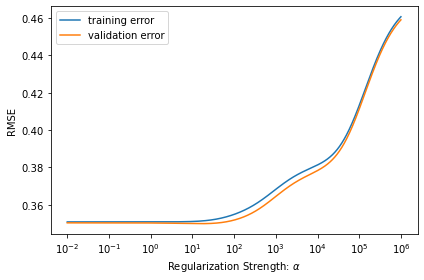

In [10]:
fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(1, 1, 1)
ax.set_xscale('log')
ax.plot(alphas, RMSE_train, label='training error')
ax.plot(alphas, RMSE_val, label='validation error')
ax.set_xticks(np.logspace(-2, 6, 9))
ax.set_xlabel('Regularization Strength: $\\alpha$')
ax.set_ylabel('RMSE')
ax.legend()
fig.tight_layout()

In [11]:
print(f'\u03B1 with minimum validation error: {alphas[RMSE_val.argmin()]}')

α with minimum validation error: 15.388177500383463


Plot the ridge trace.

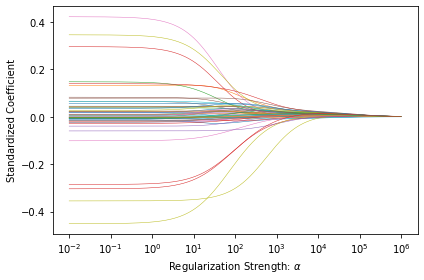

In [14]:
fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(1, 1, 1)
ax.set_xscale('log')
ax.plot(alphas, coefs, linewidth=.5)
ax.set_xticks(np.logspace(-2, 6, 9))
ax.set_xlabel('Regularization Strength: $\\alpha$')
ax.set_ylabel('Standardized Coefficient')
# ax.legend(feature_names)
fig.tight_layout()

Coefficients seem to stabalize at around $\alpha={1}\mathrm{e}{4}$, and the validation error is also near a minimum at that $\alpha$. Therefore, use $\alpha={1}\mathrm{e}{4}$ as the final hyperparameter and apply the model to the testing set. Alternatively, can also use $\alpha=15.388$ directly as it had the lowest validation error.

In [15]:
model = Ridge(alpha=1e4).fit(np.vstack((X_train,X_val)), np.concatenate((y_train,y_val)))
y_hat = model.predict(X_test)

Look at the model's performance on the testing set.

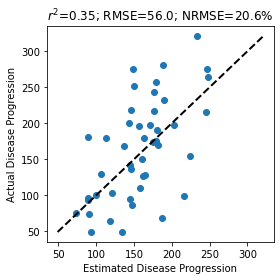

In [15]:
def plot_performance(y_test, y_hat):
    # coefficient of determination
    r2 = r2_score(y_test, y_hat)  
    # root mean square error (unit: mg/L)
    rmse = np.sqrt(np.mean(np.square(y_test - y_hat)))  
    # RMSE normalized to the value range of the target variable (unit: %)
    nrmse = rmse / np.ptp(y_test)  

    fig = plt.figure(figsize=(4, 4))
    ax = fig.add_subplot(1, 1, 1)
    ax.scatter(y_hat, y_test)
    min_, max_ = min(y_hat.min(), y_test.min()), max(y_hat.max(), y_test.max())
    # Perfect estimation line
    x = np.linspace(min_, max_, 100)  
    ax.plot(x, x, linestyle='--', color='k', linewidth=2)
    ax.set_xlabel('Estimated Disease Progression')
    ax.set_ylabel('Actual Disease Progression')
    ax.set_title('$r^2$={:.2f}; RMSE={:.1f}; NRMSE={:.1f}%'.format(r2, rmse, nrmse * 100))
    fig.tight_layout()
    
plot_performance(y_test, y_hat)

Instead of validating model hyperparameters against a fixed split of the data, employ $k$-fold cross validation. During model training, split the data into $k=10$ folds, train a model on $k-1$ folds, and validate the model against a witheld validation fold. By training $k$ models and pooling the validation results, it uses all the training data to validate the previous choice of $\alpha$.

In [16]:
# Train AND validate on 90% of the data set
train_frac = 0.9 
# Use remaining 10% for testing set
test_frac = 1 - train_frac 

# Same seed as used above
np.random.seed(0)
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=test_frac)

10-fold cross-validation of hyper-parameters. Generate train and validate sets.

In [17]:
k = 10 
folds = list(KFold(n_splits=k, shuffle=True).split(X_train, y_train)) 

Compute pooled cross-validation perfomance for each value of $\alpha$.

In [18]:
performance = np.zeros(alphas.shape)
for i, alpha in enumerate(alphas):
    y_hat = np.zeros(y_train.shape)
    for train_idx, val_idx in folds:
        # Split data into train and validate sets
        X_train_fold = X_train[train_idx]
        X_val_fold = X_train[val_idx]
        y_train_fold = y_train[train_idx]
        
        # Standardize data
        scaler = StandardScaler().fit(X_train_fold)
        X_train_fold = scaler.transform(X_train_fold)
        X_val_fold = scaler.transform(X_val_fold)
        
        # Train a model for the current fold
        model = Ridge(alpha=alpha).fit(X_train_fold, y_train_fold)
        
        # Pool the estimation results of the validation sets
        y_hat[val_idx] = model.predict(X_val_fold)
        
    # Compute performance of pooled results
    performance[i] = rmse(y_train, y_hat)

Choose the setting of $\alpha$ with the best cross-validation performance. The performance is visualized below as a function of $\alpha$.

Best α = 143.27029534098295


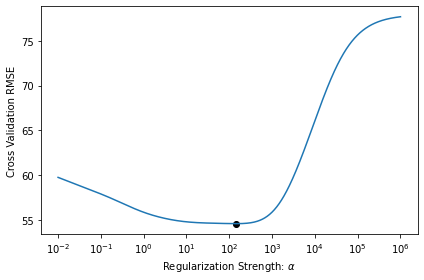

In [19]:
best_alpha = alphas[performance.argmin()]
print(f'Best \u03B1 = {best_alpha}')

fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(1, 1, 1)
ax.set_xscale('log')
ax.plot(alphas, performance)
ax.scatter([best_alpha], [performance.min()], color='k')
ax.set_xticks(np.logspace(-2, 6, 9))
ax.set_xlabel('Regularization Strength: $\\alpha$')
ax.set_ylabel('Cross Validation RMSE')
fig.tight_layout()

Train a model using the best selected $\alpha$ and all training data annd look at its performance.

In [22]:
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

model = Ridge(alpha=best_alpha).fit(X_train, y_train)
y_hat = model.predict(X_test)

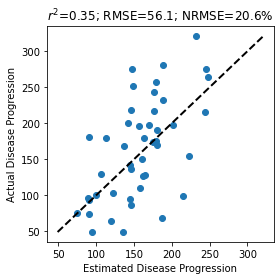

In [23]:
plot_performance(y_test, y_hat)